# Estudio comparativo de métodos de agrupación (HDBSCAN, GMM)

**Universidad Nacional de Colombia**

*David Fernando Parada Brijalba,* 
*Rosmer Manuel Vargas Contreras y*
*Joan Sebastian Franco Jimenez*

## Introducción

Los algoritmos de agrupamiento de los datos más conocidos, no siempre generan resultados correctos en contextos de alta dimensionalidad o bajo la presencia de datos atípicos los cuales pueden mostrar una alteración en la forma natural en la cual los datos se agrupan. El agrupamiento espacial basado en densidad de aplicaciones con ruido jerárquico o HDBSCAN por sus siglas en inglés, es un algoritmo de agrupamiento de datos basado en densidades, dado que construye los grupos de datos estimando las distribuciones de densidad de cada uno de ellos, comenzando por los nodos correspondientes. 

## Nota Historica

El algoritmo HDBSCAN, desarrollado por Campello, Moulavi, and Sander. en el 2013 como una mejora a su predeseror, el DBSCAN, el cual fue propuesto por Martin Ester, Hans-Peter Kriegel, Jörg Sander y Xiaowei Xu en 1996

## Entendiendo el HDBSCAN y la agrupación en clústeres basada en la densidad

*Nota:* Esta sección esta basada en la lectura de Towards Data Science por [Pepe Berba](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)

El objetivo principal de esta sección es mostrar los conceptos clave que te ayudarán a comprender cómo y por qué funciona el algoritmo de agrupamiento HDBSCAN.
 
Recordemos que el algoritmo HDBSCAN es una técnica de agrupamiento robusta y basada en densidades, así que como tal, podemos advertir que a priori no tenemos ningún supuesto que verificar.

Empecemos por lo más alto. Antes incluso de describir nuestro algoritmo de agrupamiento, debemos preguntarnos, "¿qué tipo de datos estamos tratando de agrupar?" Queremos tener la menor cantidad posible de suposiciones sobre nuestros datos. Quizás las únicas suposiciones que podemos hacer con seguridad son:

1. Hay ruido en nuestros datos
2. Hay grupos en nuestros datos que esperamos descubrir



In [29]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
rcParams['figure.figsize'] = 10, 7
%matplotlib inline

C:\Users\dfdop\AppData\Local\Temp\ipykernel_19120\3986875895.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [35]:
data = np.load('C:/Users/dfdop/Documents/Data-Mining/HDBSCAN-y-GMM/clusterable_data.npy')
colum_names = ["X","Y"]
data_df = pd.DataFrame(data,columns = colum_names)
data_df.head()

,X,Y
0,-0.121535,-0.228763
1,-0.220937,-0.252511
2,0.125904,-0.273143
3,-0.164537,-0.222244
4,-0.180824,-0.211075


In [27]:
data[:,1]

array([-0.22876337, -0.25251088, -0.27314321, ..., -0.3002958 ,
        0.19412199, -0.2092721 ])

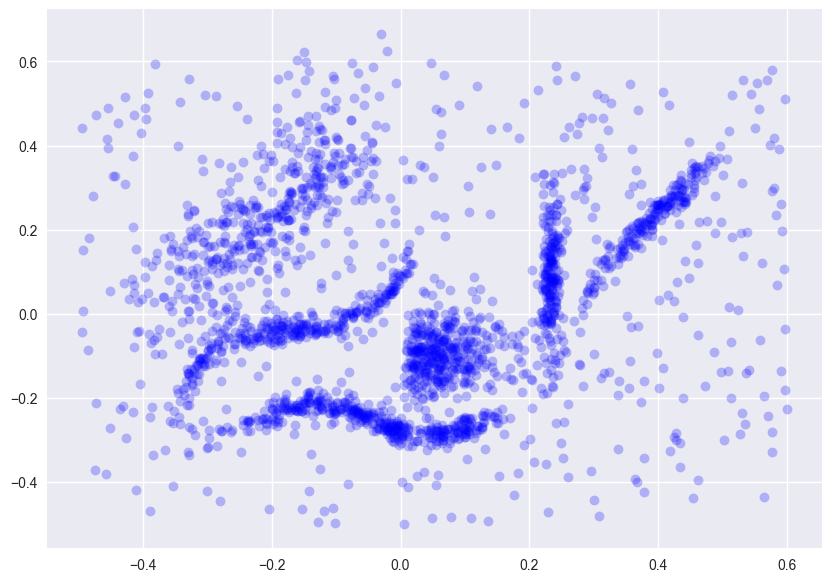

In [43]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

<AxesSubplot: xlabel='X', ylabel='Y'>

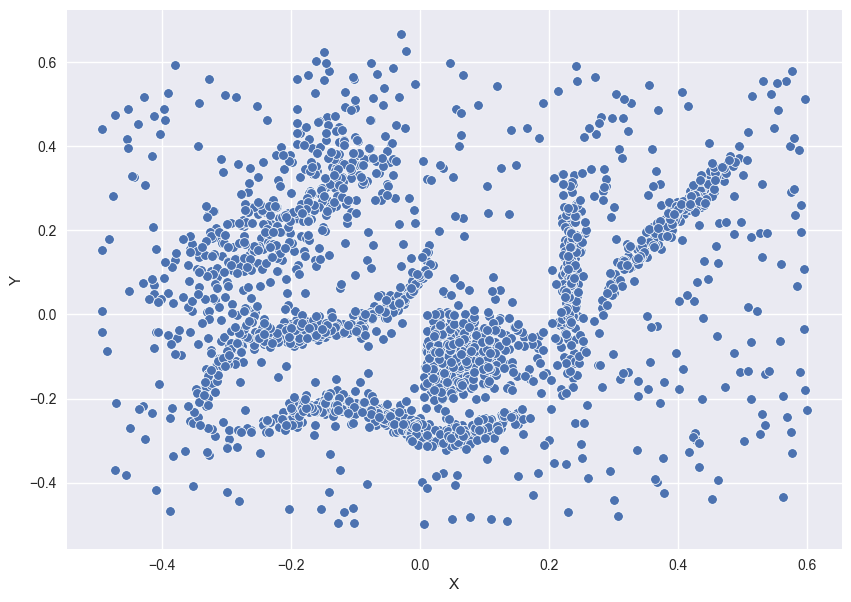

In [39]:
sns.scatterplot(data=data_df, x="X", y="Y")

## Fundamento Matematico

### Revision del DBSCAN

Sea $\textbf{X} = \left\{\textbf{x}_1, \dots, \text{x}_n \right\}$ un conjunto de $n$ observaciones tales que $\textbf{x}_i \in \mathbb{R}^m$ para $i = 1, \dots, n$ y sea $D$ una matriz de orden $n \times n$ que tiene todas las distancias entre puntos $d\left(\textbf{x}_p, \textbf{x}_q\right)$ con $\textbf{x}_p, \textbf{x}_q \in \textbf{X}$, para una métrica de distancia dada $d\left(\cdot,\cdot\right)$. 

$\textbf{Definición 1.}$ (Punto Nucleo): Un punto $\textbf{x}_i$ es llamado un punto nucleo, si para una distancia dada $\varepsilon$ hay almenos $m_{pts}$ puntos a su alrededor, i.e., si $\mid\text{N}_{\varepsilon}\left(\textbf{x}_i\right)\mid \geq m_{pts}$, donde $\text{N}_{\varepsilon}\left(\textbf{x}_i\right) = \left\{\textbf{x} \in \textbf{X} \mid d\left(\textbf{x},\textbf{x}_i\right) \leq \varepsilon\right\}$ y $\mid\cdot\mid$ denota la cardinalidad del conjunto. Un punto sera llamado ruido si este no es un punto nucleo.

$\textbf{Definición 2.}$ ($\varepsilon$-Alcanzable): Se dirá que dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ son $\varepsilon$-alcanzables con respecto a $\varepsilon$ y $m_{pts}$ si $\textbf{x}_p \in \text{N}_{\varepsilon}\left(\textbf{x}_q\right)$ y $\textbf{x}_q \in \text{N}_{\varepsilon}\left(\textbf{x}_p\right)$.

$\textbf{Definición 3.}$ (Conectados por Densidad): Dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ estan Conectados por densidad con respecto a $\varepsilon$ y $m_{pts}$ si son directa o transitivamente $\varepsilon$-alcanzables.

$\textbf{Definición 4.}$ (Cluster): Un cluster $\textbf{C}$ con respecto a $\varepsilon$ y $m_{pts}$ es un subconjunto maximal no vacío de $\textbf{X}$ tal que para cada par de puntos in $\textbf{C}$ estos están conectados por densidad 

Basado en las cuatro definiciones anteriores se puede construir la nueva versión DBSCAN* la cual es similar al DBSCAN. Recuerde que los clusters son construidos en base a las conecciones de los componentes de un gráfico particular en el cual los puntos de $\textbf{X}$ son los vértices, y cada par de puntos son adyacentes entre si, si y sólo si los dos puntos seleccionados son $\varepsilon$-alcanzables con respecto a los valores escogidos para $\varepsilon $ y $m_{pts}$

Note que en la definición original del DBSCAN también se incluye la definición de *punto frontera* la cual dice que: Un punto es frontera si este no es un punto núcleo pero se encuentra dentro de una $\varepsilon$-vecindad de un punto núcleo. 


###  Hierarchical DBSCAN* - HDBSCAN

En esta sección se introducirá la construcción del método de agrupamiento jerárquico llamado HDBSCAN, este método está basado principalmente en su hermano mayor el DBSCAN, teniendo en general varias diferencial las cuales hacen superior al HDBSCAN. A continuación se introducen unas nuevas definiciones necesarias para la construcción de este nuevo algoritmo.

$\textbf{Definicion 5.}$ (Distancia Núcleo): La distancia núcleo de un punto $\textbf{x}_p \in \textbf{X}$ con respecto a $m_{pts}$, se dira que $d_{core}\left(\textbf{x}_p\right)$ es la distancia de $\textbf{x}_p$ con respecto a sus $m_{pts}$-vecinos más cercanos incluyendo al mismo punto $\textbf{x}_p$ 

$\textbf{Definición 6.}$ (Punto nucleo-$\varepsilon$): Un punto $\textbf{x}_p\in \textbf{X}$ es llamado Punto nucleo-$\varepsilon$ para cada valor de $\varepsilon $ que sea mayor o igual a la distancia núcleo del punto $\textbf{x}_p$ con respecto a $m_{pts}$, i.e., $d_{core}\left(\textbf{x}_p\right) \leq \varepsilon$

$\textbf{Definición 7.}$ (Distancia de alcance mutuo): La distancia de alcance mutuo entre dos puntos $\textbf{x}_p$ y $\textbf{x}_q$ en $\textbf{X}$ con respecto a $m_{pts}$ está definida de la siguiente forma:  $$d_{mreach}\left(\textbf{x}_p, \textbf{x}_q\right) = \text{Max}\left\{ d_{core}\left(\textbf{x}_p\right), d_{core}\left(\textbf{x}_q\right),d\left(\textbf{x}_p, \textbf{x}_q\right)\right\}$$

$\textbf{Definición 8.}$ (Gráfico de Alcance Mutuo): Este es un gráfico completo, al cual llamaremos $G_{m_{pts}}$, en el cual los puntos de $\textbf{X}$ son vértices y el peso de cada borde es la distancia de alcance mutuo entre cada respectivo par de puntos, todo esto nuevamente con respecto a $m_{pts}$. 




### Construccion de los Clusters

Sin pérdida de generalidad, primero se supondrá que los datos provienen de una población con distribución continua, la cual se supondrá que cuenta con más de una moda con diferentes frecuencias relativas, los clusters de densidad-contorno de la función de densidad dada $f\left(x\right)$ estarán definidos como los subconjuntos que se encuentran con la mayor conexión posible definidos como $\left\{x \mid f\left(x\right) \geq \lambda\right\}$
donde $\lambda$ corresponde a un nivel de densidad dado. La mayoría de algoritmos de agrupación son una extensión de este concepto, la gran diferencia está en que este método estima la función de densidad y los subconjuntos máximo conectados, e.g., el método DBSCAN* estima los grupos de contorno de densidad para un nivel de densidad $\lambda = 1/\varepsilon$ y el valor de $m_{pts}$ es estimado mediante la metodología $K-NN$.   

La nueva alternativa HDBSCAN lo que consigue es calcular todas las posibles soluciones del DBSCAN* con respecto a un valor de $m_{pts}$ dado y todos los posibles valores de $\lambda = 1/\varepsilon$ en el intervalo $[0, \infty)$.

Con el fin de darle una formalidad teórica a este concepto, se adaptara la noción de exceso de masa propuesta por Muller, D.W., Sawitzki, G. Imagine que se aumenta el nivel de densidad $\lambda$ y suponga que un grupo de contorno de densidad $\textbf{C}_i$ aparece en el nivel $\lambda_{min}\left(\textbf{C}_i\right)$. El exceso de masa de $\textbf{C}_i$ está definido en la ecuación (1) y lo podemos ver ilustrado en la figura 1, donde las áreas sombreadas más oscuras representan el exceso de masa de los tres clusters, $\textbf{C}_3, \textbf{C}_4$ y $\textbf{C}_5$. el exceso de masa de $\textbf{C}_2$ (No resaltado en la figura) engloba las de sus descendientes $\textbf{C}_4$ y $\textbf{C}_5$.


\begin{align}
    	E\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(f\left(x\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
    \end{align}

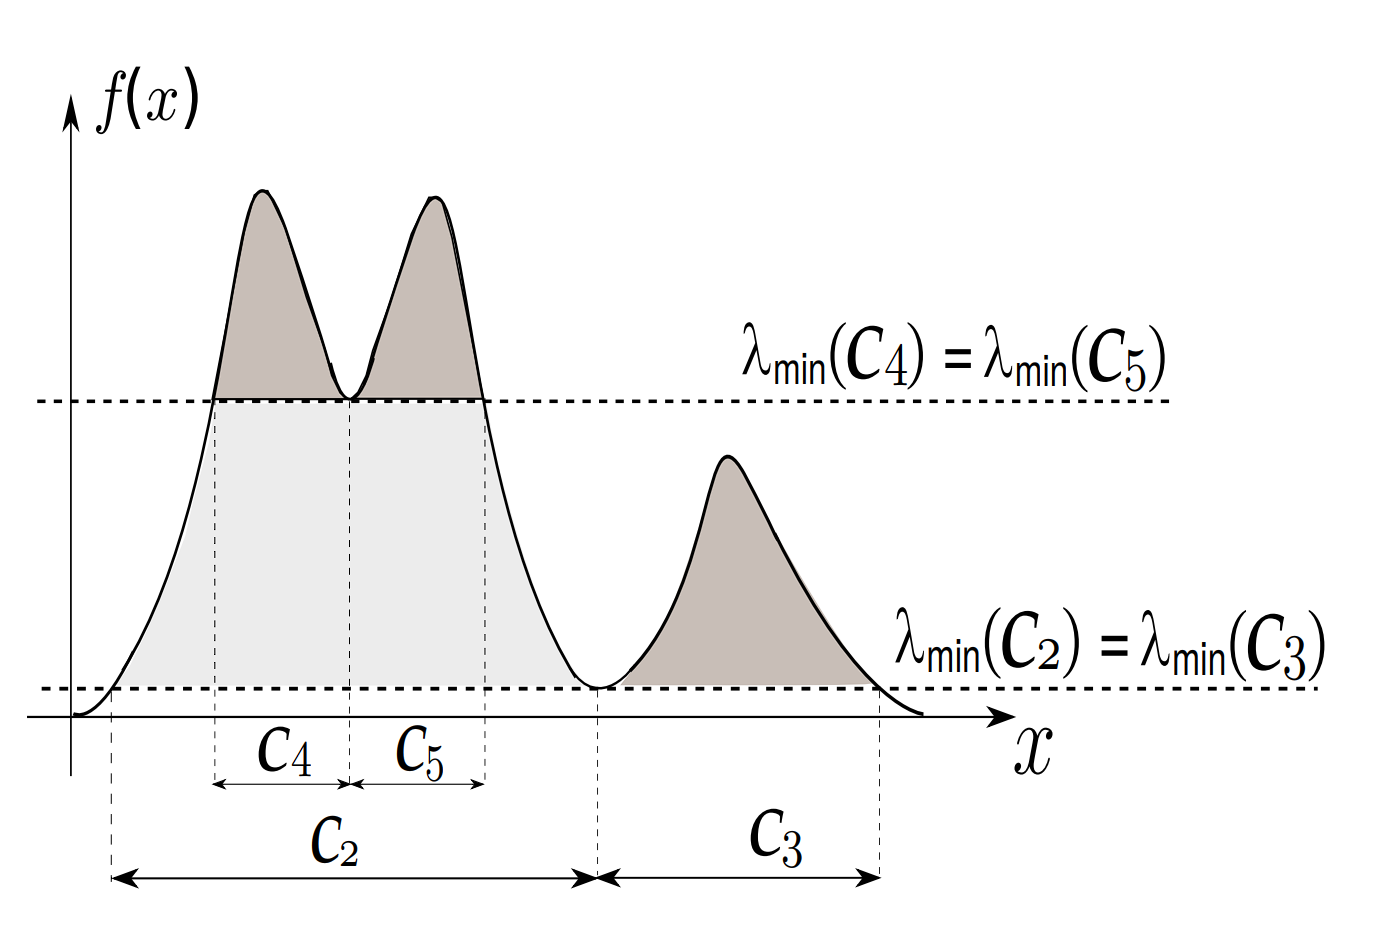

In [1]:
from IPython.display import Image
Image(filename = "density.png", width = 600, height = 400)

$\textbf{Figura 1}$ Ilustracion de la funcion de densidad, clusters y exceso de masa.

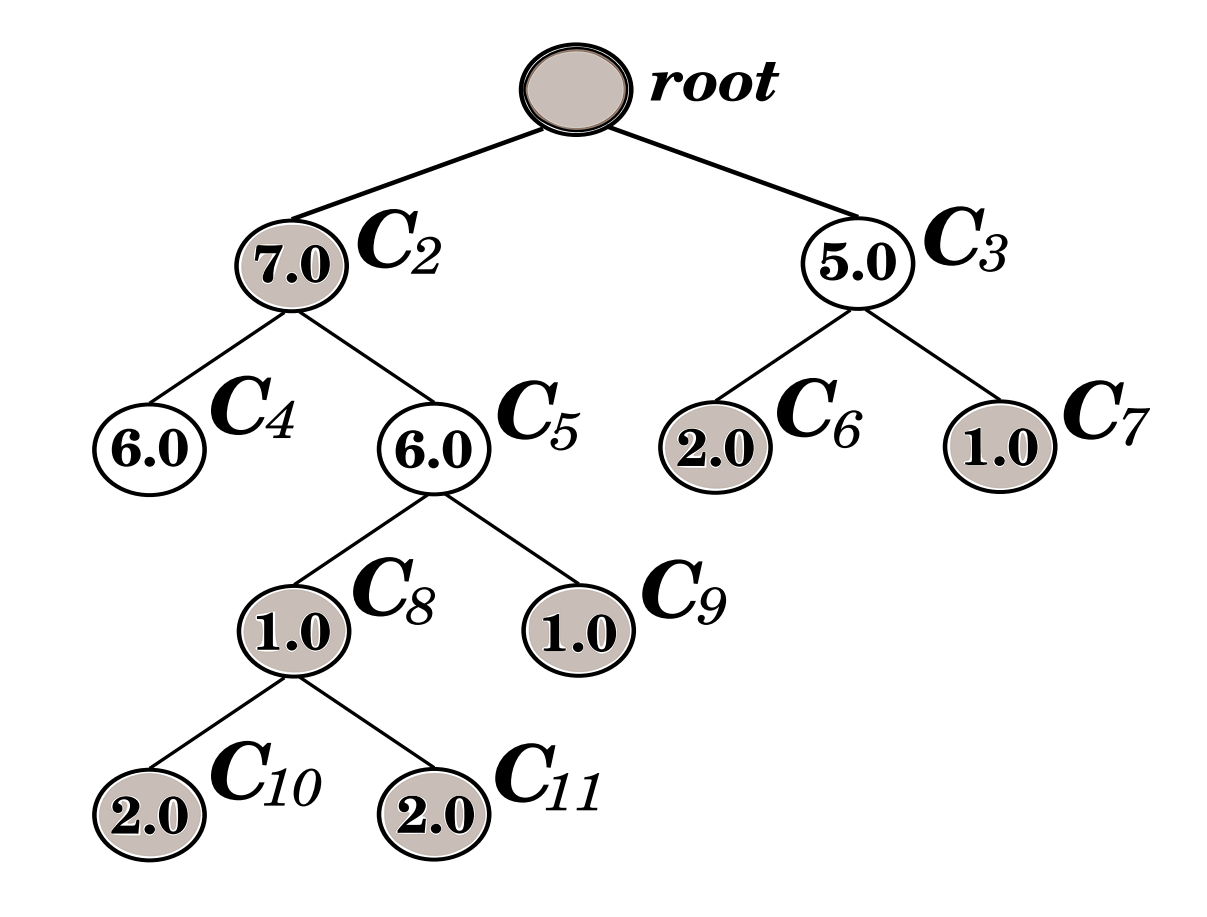

In [2]:
Image(filename = "tree.png", width = 600, height = 400)

$\textbf{Figura 2}$ Ilustracion de la seleccion optima de clusters para un árbol de cluster dado.

El exceso de masa exhibe un comportamiento monótono a lo largo de cualquier rama del árbol de conglomerados jerárquicos. Como consecuencia, esta medida no se puede utilizar para comparar las estabilidades de los clústeres anidados, como $\textbf{C}_2$ contra $\textbf{C}_4$ y $\textbf{C}_5$. Con el fin de realizar esta comparacion, se introduce la nocion de *exceso de masa relativo* para un cluster $\textbf{C}_i$ el cual aparece al nivel de densidad $\lambda_{min}\left(\textbf{C}_i\right)$ como:

\begin{align}
    	E_R\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
\end{align}

Donde $\lambda_{max}\left(x,\textbf{C}_i\right)= \text{min}\left\{f\left(x\right), \lambda_{max}\left(\textbf{C}_i\right)\right\}$ y $\lambda_{max}\left(\textbf{C}_i\right)$ es el nivel de densidad para el cual $\textbf{C}_i$ se divide o desaparece, e.g., para el cluster $\textbf{C}_2$ en la Figura 1 se puede deducir que $\lambda_{max}\left(\textbf{C}_2\right)=\lambda_{min}\left(\textbf{C}_4\right)=\lambda_{min}\left(\textbf{C}_5\right)$. Así se puede apreciar que el exceso de masa realitvo esta representado por el área sombreada más clara en la Figura 1.

Para el caso de la vida real cuando se tiene un conjunto de datos $\textbf{X}$ limitado, se propone adaptar la Ecuacion 2 con el fin de obtener una forma empirica de medir la estabilidad del cluster $\textbf{C}_i$. Teniendo asi el siguiente resultado:

\begin{align}
    	S\left(\textbf{C}_i\right) &= \sum_{x_j \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right) \\
		&= \sum_{x_j \in \textbf{C}_i} \left(\frac{1}{\varepsilon_{min}\left(\textbf{x}_j, \textbf{C}_i\right)} - \frac{1}{\varepsilon_{max}\left(\textbf{C}_i\right)}\right)
\end{align}

Donde $\lambda_{min}\left(\textbf(C)_i\right)$ es el nivel de densidad minima para el cual $\textbf{C}_i$ existe, $\lambda_{max}\left(\textbf{x}_j,\textbf{C}_i\right)$ es el nivel de densidad a partir del cual el objeto $\textbf{x}_j$ deja de pertenecer al grupo $\textbf{C}_i$, y $\varepsilon_{max}\left(\textbf{C}_i\right)$ y $\varepsilon_{min}\left(\textbf{x}_j,\textbf{C}_i\right)$ son los valores correspondientes al valor de umbral $\varepsilon$ para cada caso.


## Implementacion

## Ejemplos de aplicacion  

## Ejercicios para el Lector

## Referencias

1. Campello, R.J.G.B., Moulavi, D., Sander, J. (2013). Density-Based Clustering Based on Hierarchical Density Estimates. In: Pei, J., Tseng, V.S., Cao, L., Motoda, H., Xu, G. (eds) Advances in Knowledge Discovery and Data Mining. PAKDD 2013. Lecture Notes in Computer Science(), vol 7819. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-37456-2_14
2. L. McInnes and J. Healy, "Accelerated Hierarchical Density Based Clustering," 2017 IEEE International Conference on Data Mining Workshops (ICDMW), 2017, pp. 33-42, doi: 10.1109/ICDMW.2017.12.